# Bitcoin-JPY 週足, Parabolic SAR

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'BTC-JPY'
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='2y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-16 00:00:00+00:00,2706813.50,3016344.25,2698985.75,2939810.5,11136085551882,0.0,0.0
2023-01-23 00:00:00+00:00,2939897.50,3106836.25,2917427.75,3086949.0,23058026878840,0.0,0.0
2023-01-30 00:00:00+00:00,3086959.75,3104428.50,2954373.00,3031667.5,22270816720305,0.0,0.0
2023-02-06 00:00:00+00:00,3031450.50,3069258.75,2830188.25,2866418.0,22393608392314,0.0,0.0
2023-02-13 00:00:00+00:00,2866259.50,3372229.50,2845130.25,3267524.5,27960316754853,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+00:00,15209320.00,15692091.00,14516640.00,15023911.0,49213213055247,0.0,0.0
2024-12-30 00:00:00+00:00,15025509.00,15548012.00,14326761.00,15442245.0,40583491668947,0.0,0.0
2025-01-06 00:00:00+00:00,15441880.00,16242696.00,14421741.00,14911733.0,53478867914831,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 週足チャートとパラボリック SAR

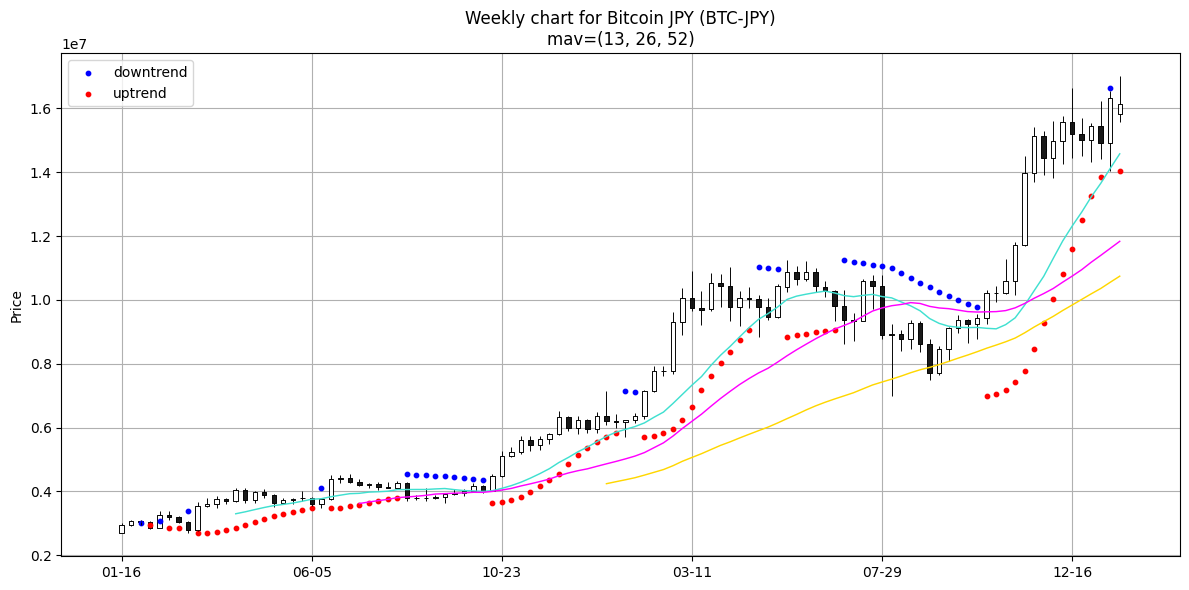

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(13, 26, 52),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Weekly chart for %s (%s)\nmav=(13, 26, 52)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s\nmav=(13, 26, 52)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('weekly_chart_exchange_psar.png')
plt.show()

In [4]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-20 00:00:00+00:00,15813822.0,17014796.0,15559075.0,16148460.0,21897997713408,0.0,0.0


In [5]:
df.tail(2)['Close']

Date
2025-01-13 00:00:00+00:00    16317415.0
2025-01-20 00:00:00+00:00    16148460.0
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-01-13 00:00:00+00:00         NaN
2025-01-20 00:00:00+00:00   -168955.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(26).mean().tail(5)

Date
2024-12-23 00:00:00+00:00    1.094751e+07
2024-12-30 00:00:00+00:00    1.118100e+07
2025-01-06 00:00:00+00:00    1.139491e+07
2025-01-13 00:00:00+00:00    1.161566e+07
2025-01-20 00:00:00+00:00    1.183578e+07
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(52).mean().tail(5)

Date
2024-12-23 00:00:00+00:00    1.001631e+07
2024-12-30 00:00:00+00:00    1.019092e+07
2025-01-06 00:00:00+00:00    1.035834e+07
2025-01-13 00:00:00+00:00    1.055344e+07
2025-01-20 00:00:00+00:00    1.074396e+07
Name: Close, dtype: float64